In [ ]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip -q install torch-spline-conv==latest+cu102 torch-scatter==latest+cu102 torch-cluster==latest+cu102 torch-sparse==latest+cu102 torch-geometric  -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip -q install torch-geometric-temporal

<h1>
<center>Attention Based Spatial-Temporal Graph Convolutional Networks
for Information diffusion prediction</center>
</h1>


In this notebook, we will dive into attentional temporal graph convolution networks where everything new meets Attention + deep learning time series analysis( temporal data) + Graph convolution all in one thing

In [ ]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import networkx as nx



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse.linalg import eigs


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='.', flush_secs=5)

import math
from typing import Optional, List, Union
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_scatter import scatter_add

## Loading the graph adjacency matrix (Spatial part)
We used 84 countries which are connected if they share borders.

In [ ]:
with open('../input/geocov19-data-preparation/Adj_matrix.npy', 'rb') as f:
    adj_mx = np.load(f) #  adj_mx  (84, 84)
    
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()

rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

# Loading the data (Temporal part)

As discussed in the previous notebook, the data(91 days) from 84 countries is splitted as follows:

The first ( 70 days )  will be used as the training set 

The next ( 11 days )  will be used as the validation set

The last ( 10 days ) will be used as the testing set

The prediction task is to use the data from the last three days (#example, 84, 1, 72) to predict the fourth day (#example, 84, 24)  , As the data will be loaded in batches of size 32, we can add the batch dimention before the #example dimention.

In [ ]:
with open('../input/geocov19-data-preparation/tweets_data_previous_hours_train.npy', 'rb') as f:
    tweets_data_previous_hours_train = np.load(f)
with open('../input/geocov19-data-preparation/tweets_data_target_train.npy', 'rb') as f:
    tweets_data_target_train = np.load(f)

with open('../input/geocov19-data-preparation/tweets_data_previous_hours_val.npy', 'rb') as f:
    tweets_data_previous_hours_val = np.load(f)
with open('../input/geocov19-data-preparation/tweets_data_target_val.npy', 'rb') as f:
    tweets_data_target_val = np.load(f)

with open('../input/geocov19-data-preparation/tweets_data_previous_hours_test.npy', 'rb') as f:
    tweets_data_previous_hours_test = np.load(f)
with open('../input/geocov19-data-preparation/tweets_data_target_test.npy', 'rb') as f:
    tweets_data_target_test = np.load(f)
    

tweets_data_previous_hours_train = np.transpose(np.expand_dims(tweets_data_previous_hours_train,-1), (0, 2, 3, 1))
tweets_data_target_train = np.transpose(tweets_data_target_train,(0,2,1))

tweets_data_previous_hours_val = np.transpose(np.expand_dims(tweets_data_previous_hours_val,-1), (0, 2, 3, 1))
tweets_data_target_val = np.transpose(tweets_data_target_val,(0,2,1))

tweets_data_previous_hours_test = np.transpose(np.expand_dims(tweets_data_previous_hours_test,-1), (0, 2, 3, 1))
tweets_data_target_test = np.transpose(tweets_data_target_test,(0,2,1))

# Creating the DataLoaders

In [ ]:
shuffle=True
DEVICE = torch.device('cuda:0')
batch_size = 16


train_x_tensor = torch.from_numpy(tweets_data_previous_hours_train).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(tweets_data_target_train).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)


val_x_tensor = torch.from_numpy(tweets_data_previous_hours_val).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
val_target_tensor = torch.from_numpy(tweets_data_target_val).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)


test_x_tensor = torch.from_numpy(tweets_data_previous_hours_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(tweets_data_target_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

print('train:', train_x_tensor.size(), train_target_tensor.size())
print('valid:', val_x_tensor.size(), val_target_tensor.size())
print('test:', test_x_tensor.size(), test_target_tensor.size())

# Defining Model Layers

## The Temporal attention layer

In the temporal dimension, there exist correlations between the traffic conditions in different time slices, and the correlations are also varying under different situations. Likewise, we use an attention mechanism to adaptively attach different importance to data. 

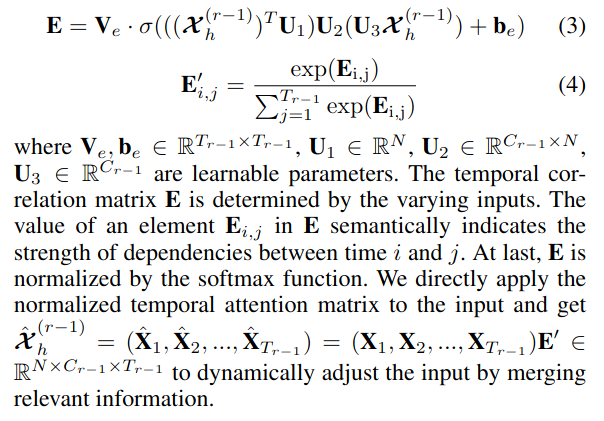



To understand the equation :

It learns to attend (focus) on which part of the time segement used as input. In our case we have 12 time points So it will generate 12 by 12 weights. 

<img src="https://i.ibb.co/NZ4fh4k/atten2.jpg" width="400">



In [ ]:
class TemporalAttention(nn.Module):
    r"""An implementation of the Temporal Attention Module. For details see this paper:
    `"Attention Based Spatial-Temporal Graph Convolutional Networks for Traffic Flow
    Forecasting." <https://ojs.aaai.org/index.php/AAAI/article/view/3881>`_

    Args:
        in_channels (int): Number of input features.
        num_of_vertices (int): Number of vertices in the graph.
        num_of_timesteps (int): Number of time lags.
    """
    
    def __init__(self, in_channels: int, num_of_vertices: int, num_of_timesteps: int, DEVICE = torch.device('cuda:0')):
        super(TemporalAttention, self).__init__()

        self._U1 = nn.Parameter(torch.cuda.FloatTensor(num_of_vertices))  # 307
        self._U2 = nn.Parameter(torch.cuda.FloatTensor(in_channels, num_of_vertices)) #(1, 307)
        self._U3 = nn.Parameter(torch.cuda.FloatTensor(in_channels)) # (1)
        self._be = nn.Parameter( torch.cuda.FloatTensor(1, num_of_timesteps, num_of_timesteps))   # (1,12,12 )
        self._Ve = nn.Parameter(torch.cuda.FloatTensor(num_of_timesteps, num_of_timesteps))  # (12, 12)
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)
                
    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """
        Making a forward pass of the temporal attention layer.

        Arg types:
            * **X** (PyTorch FloatTensor) - Node features for T time periods, with shape (B, N_nodes, F_in, T_in).

        Return types:
            * **E** (PyTorch FloatTensor) - Temporal attention score matrices, with shape (B, T_in, T_in).
        """
         # (32, 307, 1, 12) -premute-> (32, 12, 1, 307) * (307) -> (32, 12, 1) * (1, 307) 

        LHS = torch.matmul(torch.matmul(X.permute(0, 3, 2, 1), self._U1), self._U2) # (32, 12, 307) # one signal (mean of all detectors) for each timestamp then regenerate them
        # x:(B, N, F_in, T) -> (B, T, F_in, N)  lhs = left hand side embedding; rhs = right hand side embedding
        # (B, T, F_in, N)(N) -> (B,T,F_in)
        # (B,T,F_in)(F_in,N)->(B,T,N)

        
        RHS = torch.matmul(self._U3, X)   # (F)(B,N,F,T)->(B, N, T) (1)(32, 307, 1, 12) -> (32, 307, 12) # one feature (mean of all features) for each detector
        E = torch.matmul(self._Ve, torch.sigmoid(torch.matmul(LHS, RHS) + self._be)) # (B,T,N)(B,N,T)->(B,T,T) (32, 12, 307) * (32, 307, 12) -> (32, 12, 12) 
        #  (B, T, T)  (32, 12, 12)
        E = F.softmax(E, dim=1) # (32, 12, 12)
        return E

## Spatial attention layer

In the spatial dimension, the traffic conditions of different locations have influence among each other and the mutual influence is highly dynamic. Here, we use an attention mechanism (Feng et al. 2017) to adaptively capture the dynamic correlations between nodes in the spatial dimension.

<img src="https://i.ibb.co/PGnj4MR/spatial1.png" width="400">

<img src="https://i.ibb.co/G5jkKvr/spatial2.png" width="400">


The same as with the temporal attention; however, here the attention weights will be used inside a Graph convolution layer



<img src="https://i.ibb.co/stTfTFM/spat2.jpg" width="400">


In [ ]:
class SpatialAttention(nn.Module):
    r"""    compute spatial attention scores
    Args:
        in_channels (int): Number of input features.
        num_of_vertices (int): Number of vertices in the graph.
        num_of_timesteps (int): Number of time lags.
    """

    def __init__(self, in_channels: int, num_of_vertices: int, num_of_timesteps: int, DEVICE = torch.device('cuda:0')):
        super(SpatialAttention, self).__init__()

        self._W1 = nn.Parameter(torch.cuda.FloatTensor(num_of_timesteps))  # (12)
        self._W2 = nn.Parameter(torch.cuda.FloatTensor(in_channels, num_of_timesteps))   # (1, 12)
        self._W3 = nn.Parameter(torch.cuda.FloatTensor(in_channels))  # (1)
        self._bs = nn.Parameter(torch.cuda.FloatTensor(1, num_of_vertices, num_of_vertices))   #(1,307, 307)
        self._Vs = nn.Parameter(torch.cuda.FloatTensor(num_of_vertices, num_of_vertices))  # (307, 307)
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)
    
    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """
        Making a forward pass of the spatial attention layer.

        Arg types:
            * **X** (PyTorch FloatTensor) - Node features for T time periods, with shape (B, N_nodes, F_in, T_in).

        Return types:
            * **S** (PyTorch FloatTensor) - Spatial attention score matrices, with shape (B, N_nodes, N_nodes).
        """

        LHS = torch.matmul(torch.matmul(X, self._W1), self._W2) # (b,N,F,T)(T)->(b,N,F)(F,T)->(b,N,T) (32, 307, 12)
        RHS = torch.matmul(self._W3, X).transpose(-1, -2) # (F)(b,N,F,T)->(b,N,T)->(b,T,N) (32, 12, 307)
        S = torch.matmul(self._Vs, torch.sigmoid(torch.matmul(LHS, RHS) + self._bs))  # (b,N,T)(b,T,N) -> (B, N, N) (32, 307, 307)
         # (N,N)(B, N, N)->(B,N,N) (32, 307, 307)
        S = F.softmax(S, dim=1)
        return S

## Spectral graph analysis on the spatial part
Since the spatial part is represented as a graph, we will apply graph convolution to aggregate messages from neighbor nodes. The type of graph convolution that we are going to use is spectral convolution. 

* In spectral graph analysis, a graph is represented by its corresponding Laplacian matrix. 
* The properties of the graph structure can be obtained by analyzing Laplacian matrix and its eigenvalues

* Laplacian matrix of a graph is defined as L = D − A, 

* Its normalized form is L = I − ((1/ sqrt(D) A ( 1/ sqrt(D))  

where A is the adjacent matrix, I is a unit matrix, and the degree matrix D (diagnoal diagonal matrix, consisting of node degrees,at the diagonal) 

The eigenvalue decomposition of the Laplacian matrix is L = U*Λ*(U.transpose()) , where Λ = diag([λ0, ..., λN −1]) is a diagonal matrix, and U is Fourier basis. 

U is an orthogonal matrix.

The graph convolution is a convolution operation implemented by using linear operators that diagonalize in the Fourier domain to replace the classical convolution operator.

However, it is expensive to directly perform the eigenvalue decomposition on the Laplacian matrix when the scale of the graph is large. Therefore, Chebyshev polynomials are adopted to solve this problem approximately but efficiently. 






## 1. Compute graph Laplacian
The first step is to  computes the graph Laplacian of the graph given by edge_index and optional edge_weight.



In [ ]:
class ChebConvAttention(MessagePassing):
    r"""The chebyshev spectral graph convolutional operator with attention from the
    `Attention Based Spatial-Temporal Graph Convolutional
    Networks for Traffic Flow Forecasting." <https://ojs.aaai.org/index.php/AAAI/article/view/3881>`_ paper
    :math:`\mathbf{\hat{L}}` denotes the scaled and normalized Laplacian
    :math:`\frac{2\mathbf{L}}{\lambda_{\max}} - \mathbf{I}`.
    K-order chebyshev graph convolution
    Args:
        in_channels (int): Size of each input sample. num of channels in the input sequence
        out_channels (int): Size of each output sample. num of channels in the output sequence
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):
            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`
            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`
            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`
            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: int,out_channels: int,K: int, normalization: Optional[str] = None, bias: bool = True,**kwargs):
        kwargs.setdefault("aggr", "add")
        super(ChebConvAttention, self).__init__(**kwargs)
        assert K > 0
        assert normalization in [None, "sym", "rw"], "Invalid normalization"

        self._in_channels = in_channels
        self._out_channels = out_channels
        self._normalization = normalization
        self._weight = Parameter(torch.Tensor(K, in_channels, out_channels))  #    self.Theta  [3, 1, 64]
        if bias:
            self._bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter("_bias", None)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self._weight)
        if self._bias is not None:
            nn.init.uniform_(self._bias)
#------------------------------------------------------------forward
    def __norm__( self, edge_index, num_nodes: Optional[int], edge_weight: OptTensor,normalization: Optional[str],  lambda_max, 
                 dtype: Optional[int] = None, batch: OptTensor = None ):


        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)

        edge_index, edge_weight = get_laplacian(edge_index, edge_weight, normalization, dtype, num_nodes)

        if batch is not None and lambda_max.numel() > 1:
            lambda_max = lambda_max[batch[edge_index[0]]]

        edge_weight = (2.0 * edge_weight) / lambda_max
        edge_weight.masked_fill_(edge_weight == float("inf"), 0)
        #edge_index, edge_weight = add_self_loops( edge_index, edge_weight, fill_value=-1.0, num_nodes=num_nodes )
        assert edge_weight is not None
        return edge_index, edge_weight # 307 nodes as deg, 340 edges , 307 nodes as self connections

    
    def forward(self, x: torch.FloatTensor, edge_index: torch.LongTensor, spatial_attention: torch.FloatTensor, 
                edge_weight: OptTensor = None, batch: OptTensor = None, lambda_max: OptTensor = None,) -> torch.FloatTensor:
        """
        Making a forward pass of the ChebConv Attention layer.(Chebyshev graph convolution operation)

        Arg types:
            * x (PyTorch Float Tensor) - Node features for T time periods, with shape (B, N_nodes, F_in).
            * edge_index (Tensor array) - Edge indices.
            * spatial_attention (PyTorch Float Tensor) - Spatial attention weights, with shape (B, N_nodes, N_nodes).
            * edge_weight (PyTorch Float Tensor, optional) - Edge weights corresponding to edge indices.
            * batch (PyTorch Tensor, optional) - Batch labels for each edge.
            * lambda_max (optional, but mandatory if normalization is None) - Largest eigenvalue of Laplacian.

        Return types:
            * out (PyTorch Float Tensor) - Hidden state tensor for all nodes, with shape (B, N_nodes, F_out).
        """
        if self._normalization != "sym" and lambda_max is None:
            raise ValueError( "You need to pass `lambda_max` to `forward() in case the normalization is non-symmetric.")

        if lambda_max is None:
            lambda_max = torch.tensor(2.0, dtype=x.dtype, device=x.device)
        if not isinstance(lambda_max, torch.Tensor):
            lambda_max = torch.tensor(lambda_max, dtype=x.dtype, device=x.device)
        assert lambda_max is not None

        edge_index, norm = self.__norm__(edge_index, x.size(self.node_dim), edge_weight, self._normalization, lambda_max, 
                                         dtype=x.dtype, batch=batch)
        row, col = edge_index # refer to the index of each note each is a list of nodes not a number # (954, 954)
        
        Att_norm = norm * spatial_attention[:, row, col] # spatial_attention (32, 307, 307), -> (954) * (32, 954) -> (32, 954)

        num_nodes = x.size(self.node_dim) # 307
        # (307, 307) * (32, 307, 307) -> (32, 307, 307) -permute-> (32, 307,307) * (32, 307, 1) -> (32, 307, 1)
        TAx_0 = torch.matmul((torch.eye(num_nodes).to(edge_index.device) * spatial_attention).permute( 0, 2, 1), x) # (32, 307, 1)
        out = torch.matmul(TAx_0, self._weight[0]) # (32, 307, 1) * [1, 64] -> (32, 307, 64)
        edge_index_transpose = edge_index[[1, 0]]
        if self._weight.size(0) > 1: # Do once
            TAx_1 = self.propagate( edge_index_transpose, x=TAx_0, norm=Att_norm, size=None)
            out = out + torch.matmul(TAx_1, self._weight[1])

        for k in range(2, self._weight.size(0)): # Do once
            TAx_2 = self.propagate(edge_index_transpose, x=TAx_1, norm=norm, size=None)
            TAx_2 = 2.0 * TAx_2 - TAx_0
            out = out + torch.matmul(TAx_2, self._weight[k])
            TAx_0, TAx_1 = TAx_1, TAx_2

        if self._bias is not None:
            out += self._bias
        return out #? (b, N, F_out) (32, 307, 64)

    def message(self, x_j, norm):
        if norm.dim() == 1: # do this
            return norm.view(-1, 1) * x_j  # (954, 1) * (32, 954, 1) -> (32, 954, 1)
        else:
            d1, d2 = norm.shape
            return norm.view(d1, d2, 1) * x_j


    def __repr__(self):
        return "{}({}, {}, K={}, normalization={})".format(self.__class__.__name__,self._in_channels,self._out_channels,self._weight.size(0),self._normalization,)

# The ASTGCN block

In [ ]:
class ASTGCNBlock(nn.Module):
    r"""
    Args:
        in_channels (int): Number of input features.
        K (int): Order of Chebyshev polynomials. Degree is K-1.
        nb_chev_filter (int): Number of Chebyshev filters.
        nb_time_filter (int): Number of time filters.
        time_strides (int): Time strides during temporal convolution.
        num_of_vertices (int): Number of vertices in the graph.
        num_of_timesteps (int): Number of time lags.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):
            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`
            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`
            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`
            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """
    def __init__(self, in_channels: int,K: int,nb_chev_filter: int,nb_time_filter: int,time_strides: int,num_of_vertices: int,
        num_of_timesteps: int,normalization: Optional[str] = None,bias: bool = True, DEVICE = torch.device('cuda:0')):
        super(ASTGCNBlock, self).__init__()

        self._temporal_attention = TemporalAttention(in_channels, num_of_vertices, num_of_timesteps, DEVICE)
        self._spatial_attention = SpatialAttention(in_channels, num_of_vertices, num_of_timesteps, DEVICE)
        self._chebconv_attention = ChebConvAttention(in_channels, nb_chev_filter, K, normalization, bias)
        self._time_convolution = nn.Conv2d( nb_chev_filter,nb_time_filter,kernel_size=(1, 3), stride=(1, time_strides),padding=(0, 1))
        self._residual_convolution = nn.Conv2d(in_channels, nb_time_filter, kernel_size=(1, 1), stride=(1, time_strides))
        self._layer_norm = nn.LayerNorm(nb_time_filter) #channel
        self._normalization = normalization

        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)

    def forward(self, X: torch.FloatTensor, edge_index: Union[torch.LongTensor, List[torch.LongTensor]]) -> torch.FloatTensor:
        """
        Making a forward pass with the ASTGCN block.
        Arg types:
            * **X** (PyTorch Float Tensor) - Node features for T time periods, with shape (B, N_nodes, F_in, T_in).
            * **edge_index** (LongTensor): Edge indices, can be an array of a list of Tensor arrays, depending on whether edges change over time.

        Return types:
            * **X** (PyTorch Float Tensor) - Hidden state tensor for all nodes, with shape (B, N_nodes, nb_time_filter, T_out).
        """
        batch_size, num_of_vertices, num_of_features, num_of_timesteps = X.shape  # (32, 307, 1, 12)
        X_tilde = self._temporal_attention(X) # (b, T, T)  (32, 12, 12) * reshaped x(32, 307, 12)  -reshape> (32, 307, 1, 12)
        X_tilde = torch.matmul(X.reshape(batch_size, -1, num_of_timesteps), X_tilde)
        X_tilde = X_tilde.reshape(batch_size, num_of_vertices, num_of_features, num_of_timesteps)
        X_tilde = self._spatial_attention(X_tilde) # (32, 307, 307)

        if not isinstance(edge_index, list):
            data = Data(edge_index=edge_index, edge_attr=None, num_nodes=num_of_vertices)
            if self._normalization != "sym":
                lambda_max = LaplacianLambdaMax()(data).lambda_max
            else:
                lambda_max = None
            X_hat = []
            for t in range(num_of_timesteps):
                X_hat.append(torch.unsqueeze( self._chebconv_attention(X[:, :, :, t], edge_index, X_tilde, lambda_max=lambda_max), -1))

            X_hat = F.relu(torch.cat(X_hat, dim=-1))
        else:
            X_hat = []
            for t in range(num_of_timesteps):
                data = Data(edge_index=edge_index[t], edge_attr=None, num_nodes=num_of_vertices)
                if self._normalization != "sym":
                    lambda_max = LaplacianLambdaMax()(data).lambda_max
                else:
                    lambda_max = None
                X_hat.append(torch.unsqueeze(self._chebconv_attention(X[:, :, :, t], edge_index[t], X_tilde, lambda_max=lambda_max),-1,))
            X_hat = F.relu(torch.cat(X_hat, dim=-1))

        # (b,N,F,T) (32, 307, 64, 12) -premute->(32, 64, 307,12)
        # convolution along the time axis
        X_hat = self._time_convolution(X_hat.permute(0, 2, 1, 3))   # (b,N,F,T)->(b,F,N,T) (1,3)->(b,F,N,T) (32, 64, 307, 12)
        X = self._residual_convolution(X.permute(0, 2, 1, 3)) # (b,N,F,T)->(b,F,N,T) (1,1)->(b,F,N,T)  (32, 64, 307, 12)
        #-adding->(32, 64, 307, 12)-premuting-> (32, 12, 307, 64)-layer_normalization_-premuting->(32, 307, 64,12) 
        X = self._layer_norm(F.relu(X + X_hat).permute(0, 3, 2, 1))
        X = X.permute(0, 2, 3, 1)
        # (b,F,N,T)->(b,T,N,F) -ln-> (b,T,N,F)->(b,N,F,T)
        return X

# The ASTGCN model structure


The model is composed of two ASTGCN blocks followed by a final layer

Original x (input) is (32, 307, 1, 12) -Block1> (32, 307, 64, 12) -Block2> (32, 307, 64, 12) -permute-> (32, 12, 307,64) 
            # -final_conv-> (32, 12, 307, 1) -reshape-> (32,307,12) "The target"
            


The model is  the fusion of three independent components with the same structure, which are designed to respectively model the recent, daily-periodic and weekly-periodic dependencies of the historical data. This is discussed in the previous notebook (https://www.kaggle.com/elmahy/processing-traffic-data-for-deep-learning-projects). 

But in our case we will only focus on the recent segment (last hour segment) i.e. X_h  

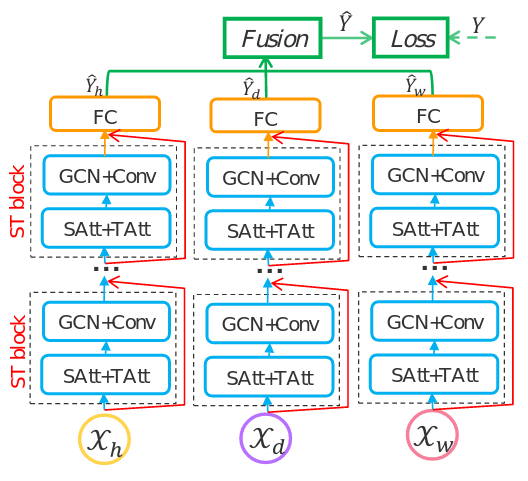

In [ ]:
class ASTGCN(nn.Module):
    r"""An implementation of the Attention Based Spatial-Temporal Graph Convolutional Cell.
    For details see this paper: `"Attention Based Spatial-Temporal Graph Convolutional
    Networks for Traffic Flow Forecasting." <https://ojs.aaai.org/index.php/AAAI/article/view/3881>`_

    Args:
        nb_block (int): Number of ASTGCN blocks in the model.
        in_channels (int): Number of input features.
        K (int): Order of Chebyshev polynomials. Degree is K-1.
        nb_chev_filters (int): Number of Chebyshev filters.
        nb_time_filters (int): Number of time filters.
        time_strides (int): Time strides during temporal convolution.
        edge_index (array): edge indices.
        num_for_predict (int): Number of predictions to make in the future.
        len_input (int): Length of the input sequence.
        num_of_vertices (int): Number of vertices in the graph.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):
            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`
            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`
            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`
            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """
        
        
    def __init__( self,  nb_block: int, in_channels: int,  K: int, nb_chev_filter: int,  nb_time_filter: int,  time_strides: int,
        num_for_predict: int,len_input: int, num_of_vertices: int, normalization: Optional[str] = None,bias: bool = True, DEVICE = torch.device('cuda:0')):

        super(ASTGCN, self).__init__()

        self._blocklist = nn.ModuleList([ASTGCNBlock( in_channels, K, nb_chev_filter, nb_time_filter,time_strides, num_of_vertices, 
                                                     len_input, normalization,bias, DEVICE)])

        self._blocklist.extend( [ASTGCNBlock( nb_time_filter,  K, nb_chev_filter, nb_time_filter, 1, num_of_vertices, 
                                             len_input // time_strides, normalization,  bias, DEVICE)  for _ in range(nb_block - 1) ]) # nb_block= 2

        self._final_conv = nn.Conv2d( int(len_input / time_strides),   num_for_predict,  kernel_size=(1, nb_time_filter))

        self._reset_parameters()

    def _reset_parameters(self):
        """
        Resetting the parameters.
        """
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            else:
                nn.init.uniform_(p)
                

    def forward(  self, X: torch.FloatTensor, edge_index: torch.LongTensor ) -> torch.FloatTensor:
        """
        Making a forward pass.

        Arg types:
            * **X** (PyTorch FloatTensor) - Node features for T time periods, with shape (B, N_nodes, F_in, T_in).
            * **edge_index** (PyTorch LongTensor): Edge indices, can be an array of a list of Tensor arrays, depending on whether edges change over time.

        Return types:
            * **X** (PyTorch FloatTensor)* - Hidden state tensor for all nodes, with shape (B, N_nodes, T_out).
        """
        for block in self._blocklist:
            X = block(X, edge_index) # original x is (32, 307, 1, 12) -> (32, 307, 64, 12) -> (32, 307, 64, 12) -permute-> (32, 12, 307,64) 
            # -final_conv-> (32, 12, 307, 1)

        X = self._final_conv(X.permute(0, 3, 1, 2))
        X = X[:, :, :, -1]
        X = X.permute(0, 2, 1) 
        # (b,N,F,T)->(b,T,N,F)-conv<1,F>->(b,c_out*T,N,1)->(b,c_out*T,N)->(b,N,T) 
        return X # (32, 307, 12)

# Initialized the ASTGCN model


In [ ]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = 1 #num_of_hours
num_for_predict = 24
len_input = 72
num_of_vertices = 84
#L_tilde = scaled_Laplacian(adj_mx)
#cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

print(net)


In [ ]:
#------------------------------------------------------
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

print('Net\'s state_dict:')
total_param = 0
for param_tensor in net.state_dict():
    print(param_tensor, '\t', net.state_dict()[param_tensor].size())
    total_param += np.prod(net.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])


# Defining the loss function

 1. masked_mae

In [ ]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)


In [ ]:
masked_flag=0
criterion = nn.L1Loss().to(DEVICE)
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0

loss_function = 'rmse'
if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

In [ ]:
criterion

In [ ]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, edge_index_data, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss

In [ ]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()

In [ ]:
masked_flag

In [ ]:
# train model
for epoch in range(10):
    params_filename = os.path.join('./', 'epoch_%s.params' % epoch)
    masked_flag = 1
    if masked_flag:
        val_loss = compute_val_loss_mstgcn(net, train_loader, criterion_masked, masked_flag,missing_value,sw, epoch,edge_index_data)
    else:
        val_loss = compute_val_loss_mstgcn(net, train_loader, criterion, masked_flag, missing_value, sw, epoch,edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(net.state_dict(), params_filename)
        print('save parameters to file: %s' % params_filename)

    net.train()  # ensure dropout layers are in train mode
    for _ in range(10):
        for batch_index, batch_data in enumerate(train_loader):
            encoder_inputs, labels = batch_data   # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
            optimizer.zero_grad()
            outputs = net(encoder_inputs, edge_index_data) # torch.Size([32, 307, 12])

            if masked_flag:
                loss = criterion_masked(outputs, labels,missing_value)
            else :
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss = loss.item()
            global_step += 1
            sw.add_scalar('training_loss', training_loss, global_step)

            if global_step % 50 == 0:
                print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))
            if global_step % 200 == 0:
                #plt.plot(np.concatenate([encoder_inputs[0][0][0].cpu().numpy(), labels[0][0].cpu().numpy()]))
                plt.plot(range(72),encoder_inputs[0][0][0].cpu().numpy(), color = 'red')
                plt.plot(range(72,96), labels[0][0].cpu().numpy(), color='blue')
                plt.show()
                plt.plot(range(72),encoder_inputs[0][0][0].cpu().numpy(), color = 'red')
                plt.plot(range(72,96), outputs[0][0].detach().cpu().numpy(), color='blue')
                plt.show()


# Testing the model

In [ ]:
net.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = net(encoder_inputs, edge_index_data)
        loss = criterion(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 100 == 0:
            print('test_loss batch %s / %s, loss: %.2f' % (batch_index + 1, test_loader_length, loss.item()))


    test_loss = sum(tmp) / len(tmp)
    sw.add_scalar('test_loss', test_loss, epoch)
print(test_loss)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(30,4), dpi=80)
for i in range(84):
    new_i = i * 24
    plt.plot(range(0+new_i,24+new_i),outputs[0][i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,24+new_i), labels[0][i].cpu().numpy(), color='blue')
plt.show()